In [1]:
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.root'

from mu2etools import *
from mu2etools import wideband
from scipy import stats

temp = 25
runlist = [1433,1435,1436,1437,1438,1439,1440,1441,1442]
bias = np.array([53.5, 54, 54.5, 55, 55.5, 56, 56.5, 57, 57.5])

In [2]:
processor = wideband.DataProcessor(usexroot=True, fixtimes=False, runlist=runlist, userunlist=True, remove=False)
arr, arSpills = processor.getData(DATASET) # get akward array for "run" tree

In [3]:
list_febID = arr['febID'].to_list()
FEBID = min(list_febID, key=lambda x: len(x))

NFEBS=len(FEBID)
print("Dataset: %s"%DATASET)
print("Number of FEBs: %d"%NFEBS)
print("List of FEBs: %s"%FEBID)

Dataset: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.root
Number of FEBs: 1
List of FEBs: [22]


In [4]:
if not np.array_equal(np.array(runlist), arr['runNumber'].to_numpy()):
    print("Input run list order and data do not match")

In [5]:
#Mask channels which were not calibrated
useRaw = True
var='calibConstantsTemperatureCorrected'
if useRaw:
    var = 'calibConstants'
    
arSPE = ak.mask(arr[var], arr[var]>0).to_numpy()

[295.664 357.455 422.312 486.554 549.481 611.386 672.081 734.377]


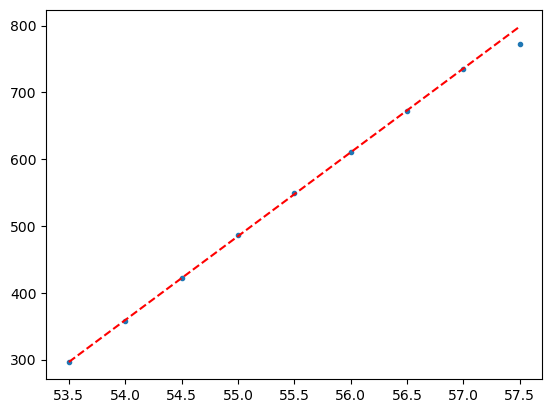

In [6]:
#Plot one channel
chan=44
x=bias
y=arSPE[:, 0, chan]
mask = ~np.isnan(y)
x=x[mask]
y=y[mask]
print(y[:-1])
plt.plot(x, y, '.');
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:-1], y[:-1])
plt.plot(x, slope * x + intercept, '--', color = 'red');

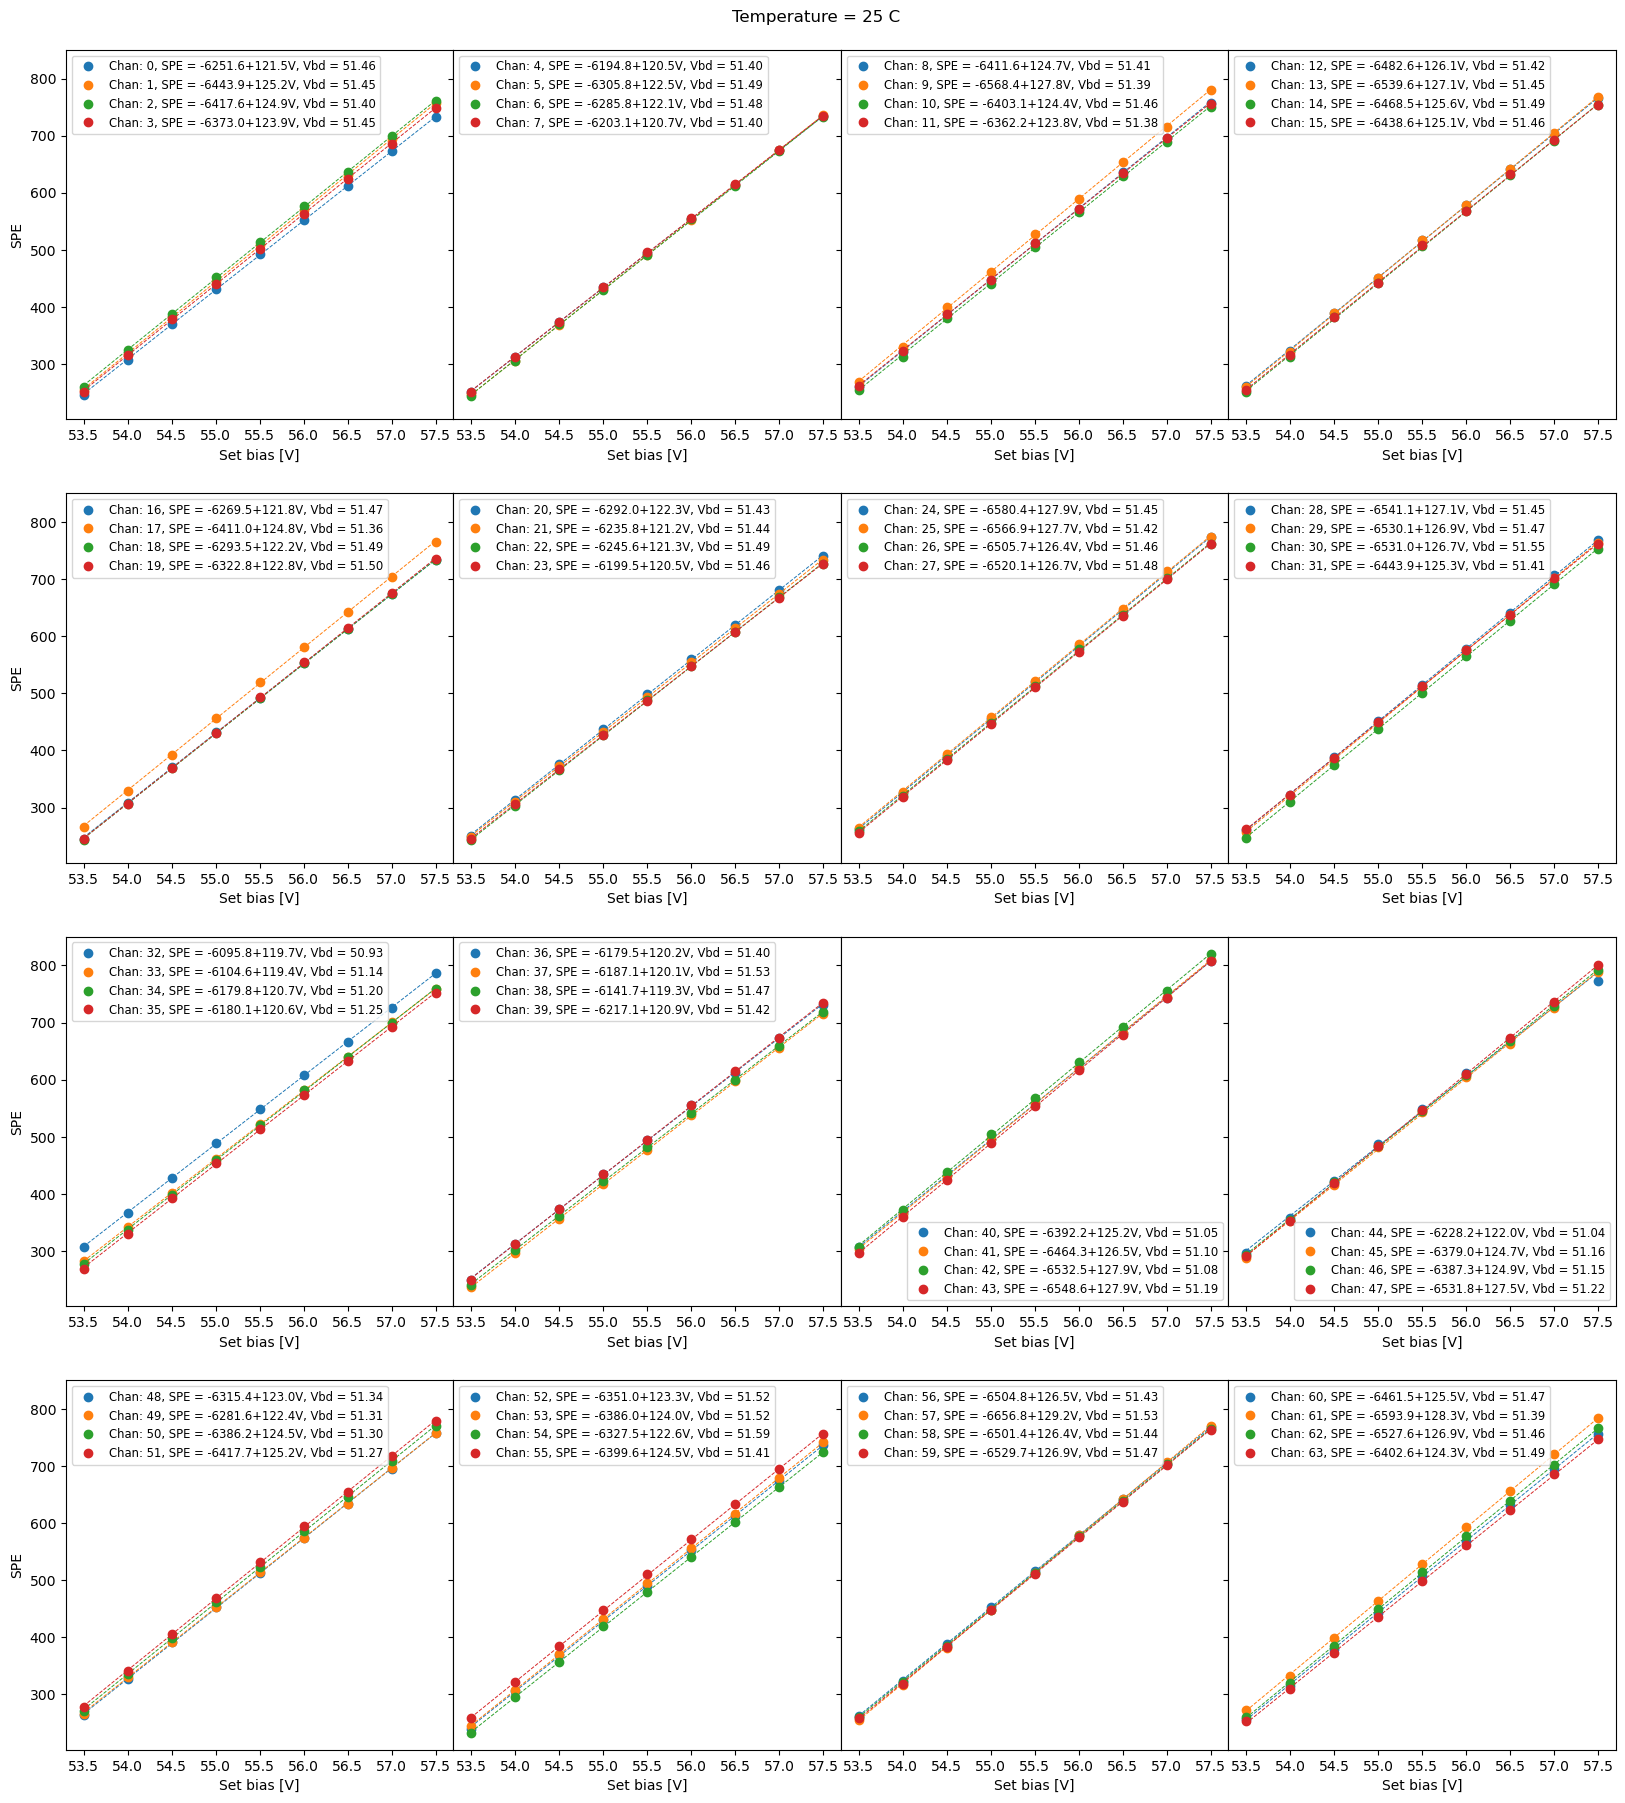

In [7]:
df = pd.DataFrame(columns=['feb', 'chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err', "Vbd"])
for feb in range(NFEBS):
    
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
    plt.subplots_adjust(wspace=0)
    fig.subplots_adjust(top=0.96)
    plt.suptitle("Temperature = %d C"%temp)

    for hdmi, ax in enumerate(axs.flatten()):
        ax.set_xlabel("Set bias [V]")
        if(hdmi%4 == 0):
            ax.set_ylabel("SPE")
        for inhdmi_chan in range(4):
            chan = hdmi*4+inhdmi_chan
            x=bias
            y=arSPE[:, feb, chan]
            mask = ~np.isnan(y)
            x=x[mask]
            y=y[mask]

            if y.size==0:
                print("Bad channel: %d, %d"%(feb,chan))
                continue

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            ratio = - intercept / slope
            ratio_stderr = ratio * np.sqrt((std_err / slope)**2)

            new_row = {'feb': feb, 'chan': chan, 'slope': slope, 'intercept': intercept,
                       'r_value': r_value, 'p_value': p_value, 'std_err': ratio_stderr, 'Vbd': ratio}
            df.loc[len(df)] = new_row

            markers = ax.plot(x, y, 'o', label='Chan: %d, SPE = %.1f+%.1fV, Vbd = %.2f'%(chan, intercept, slope, ratio))
            ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
            ax.legend(fontsize='small');

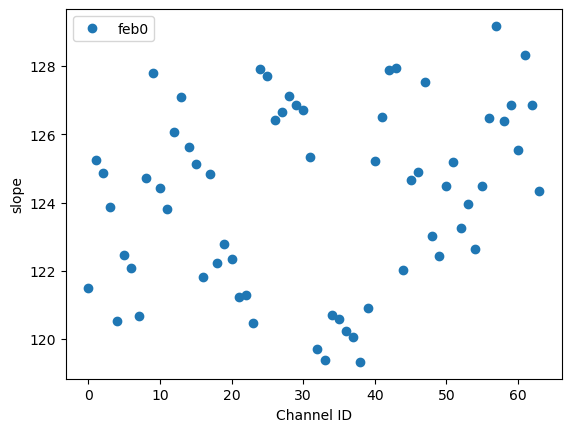

In [8]:
plt.plot(df.query('feb==0')['chan'], df.query('feb==0')['slope'], 'o', label='feb0')
plt.legend();
plt.xlabel("Channel ID")
plt.ylabel("slope");

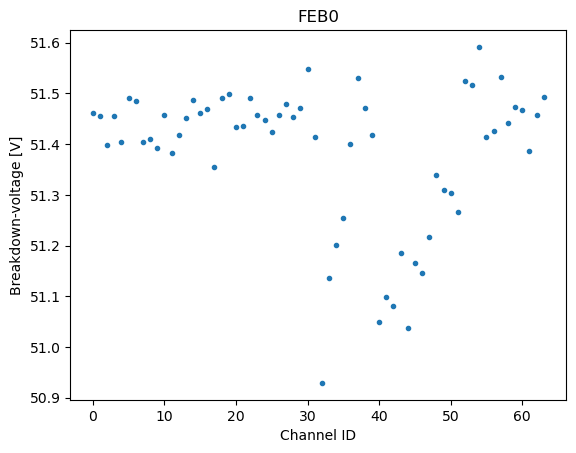

In [9]:
for feb in range(NFEBS):
    plt.title("FEB%d"%feb)
    plt.plot(df.query("feb==%d"%feb)['chan'], df.query("feb==%d"%feb)['Vbd'], '.')
    plt.xlabel("Channel ID")
    plt.ylabel("Breakdown-voltage [V]")

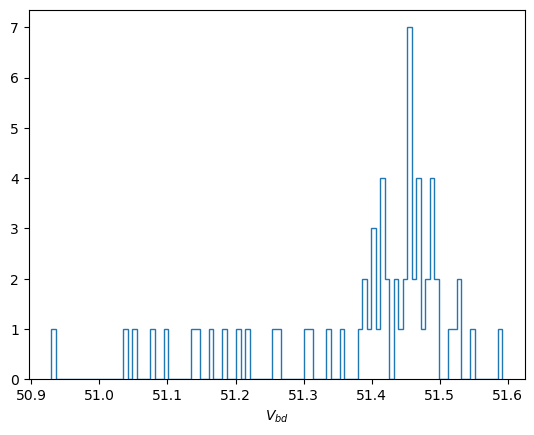

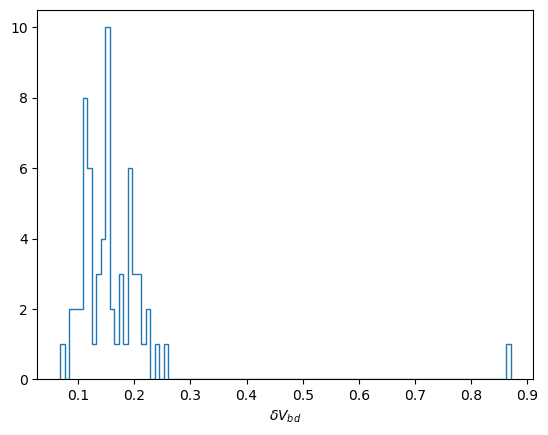

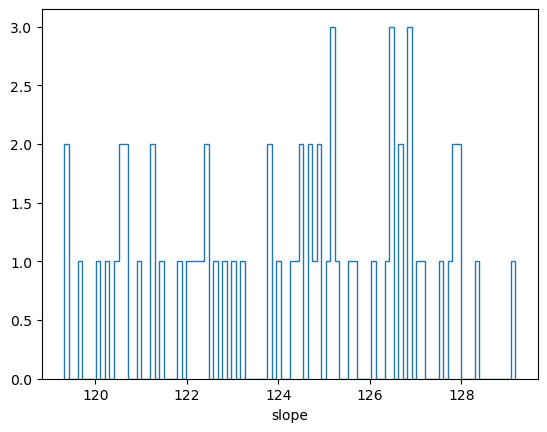

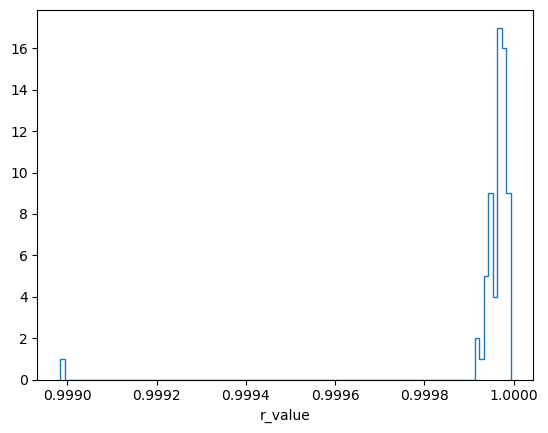

In [10]:
plt.hist(df['Vbd'], bins=100, histtype='step');
plt.xlabel('$V_{bd}$');

plt.figure()
plt.hist(df['std_err'], bins=100, histtype='step');
plt.xlabel('std_err');
plt.xlabel('$\delta V_{bd}$')

plt.figure()
plt.hist(df['slope'], bins=100, histtype='step');
plt.xlabel('slope');

plt.figure()
plt.hist(df['r_value'], bins=100, histtype='step');
plt.xlabel('r_value');

In [11]:
pd.set_option('display.max_rows', None)
df

,feb,chan,slope,intercept,r_value,p_value,std_err,Vbd
0,0,0,121.480573,-6251.615286,0.999983,6.531117e-17,0.113078,51.461852
1,0,1,125.234564,-6443.916110,0.999980,1.220840e-16,0.123632,51.454773
2,0,2,124.861470,-6417.640782,0.999949,3.057176e-15,0.195647,51.398088
3,0,3,123.855997,-6372.963506,0.999968,6.019919e-16,0.155283,51.454622
4,0,4,120.511333,-6194.773860,0.999984,5.151102e-17,0.109185,51.404077
5,0,5,122.467263,-6305.840311,0.999983,6.971855e-17,0.114201,51.490008
6,0,6,122.091268,-6285.786926,0.999970,4.854367e-16,0.150669,51.484328
7,0,7,120.673307,-6203.114862,0.999966,7.333724e-16,0.159569,51.404200
8,0,8,124.714830,-6411.630496,0.999956,1.788369e-15,0.181262,51.410330
9,0,9,127.810136,-6568.368732,0.999946,3.848666e-15,0.202164,51.391611
